<a href="https://colab.research.google.com/github/saisumedha/FMML-PROJECTS_AND_LABS/blob/main/MODULE2_LAB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

In [2]:
n_points = 1500
X, color = datasets.make_s_curve(n_points, random_state=0)

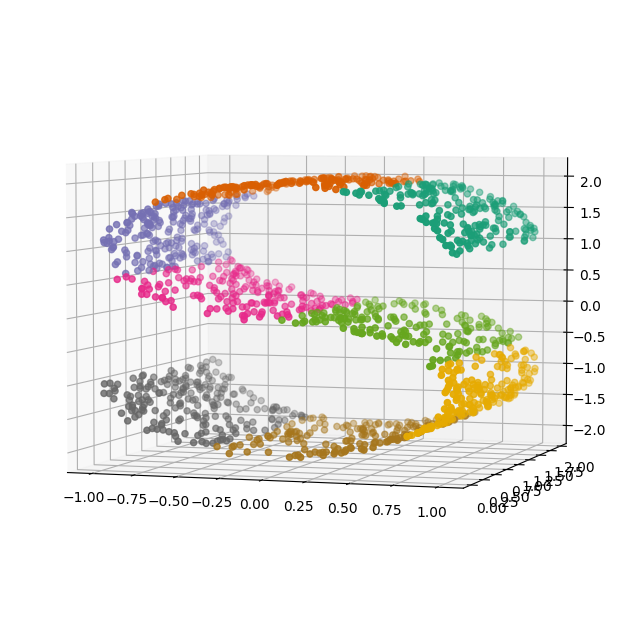

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

In [4]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1500 points, so we expect the dimensions of this matrix to be 1500x1500
print(distances.shape)

(1500, 1500)


In [5]:
# Lets keep only the 15 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 15
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [6]:
neighbors.shape

(1500, 1500)

In [7]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

In [8]:
gram = (graph ** 2)

In [10]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1500,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

In [11]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

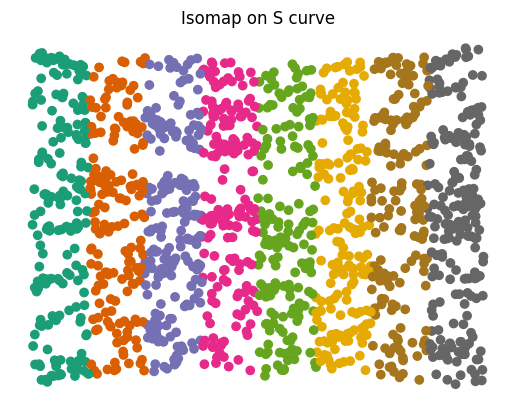

In [12]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [13]:
from sklearn.manifold import Isomap

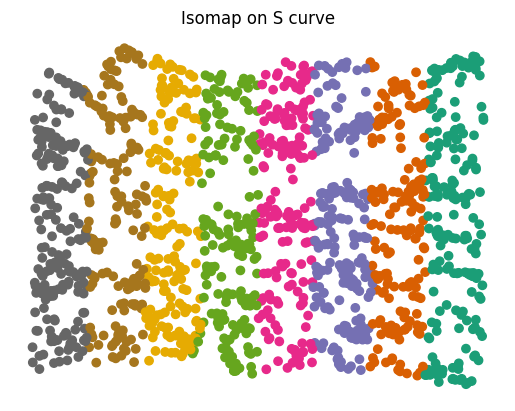

In [14]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [15]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

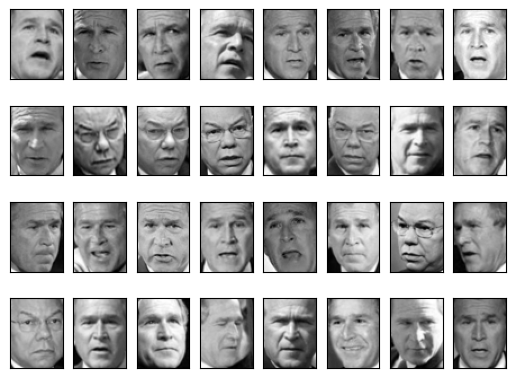

In [16]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

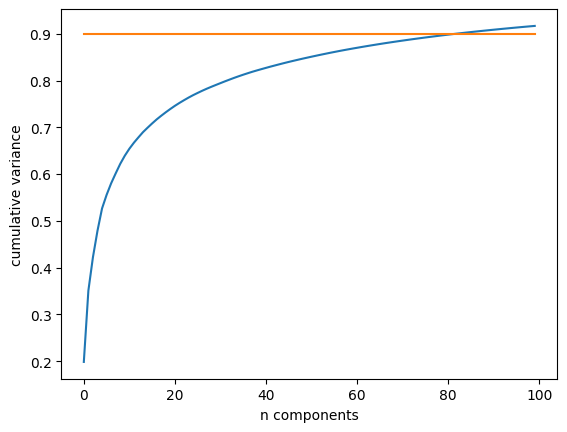

In [17]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [18]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [19]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

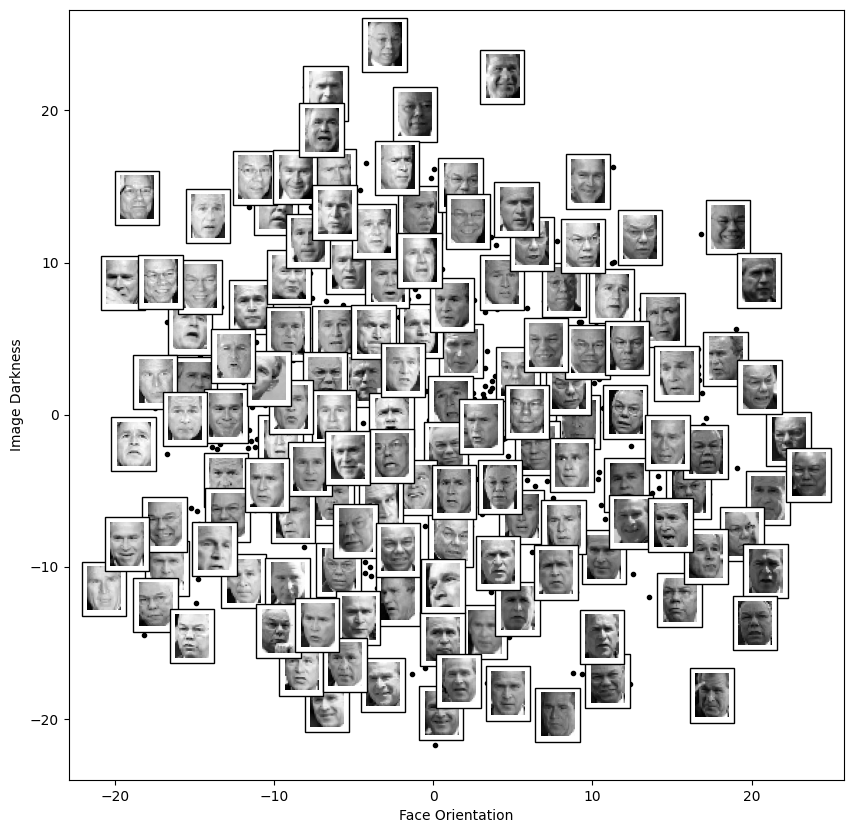

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Text(0, 0.5, 'Image Darkness')

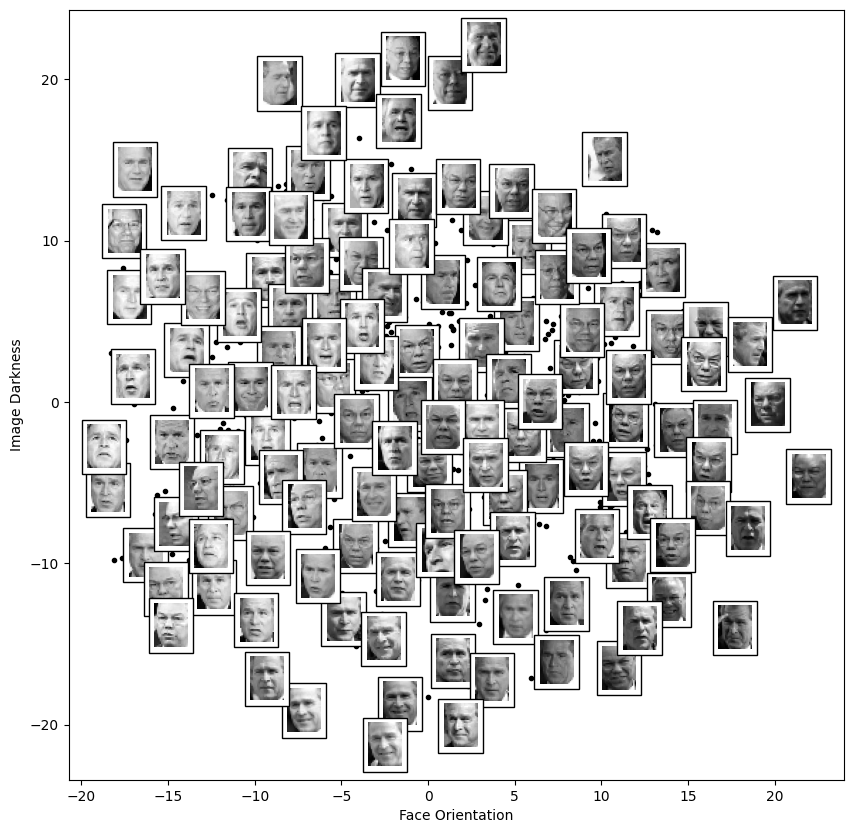

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 7),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Text(0, 0.5, 'Image Darkness')

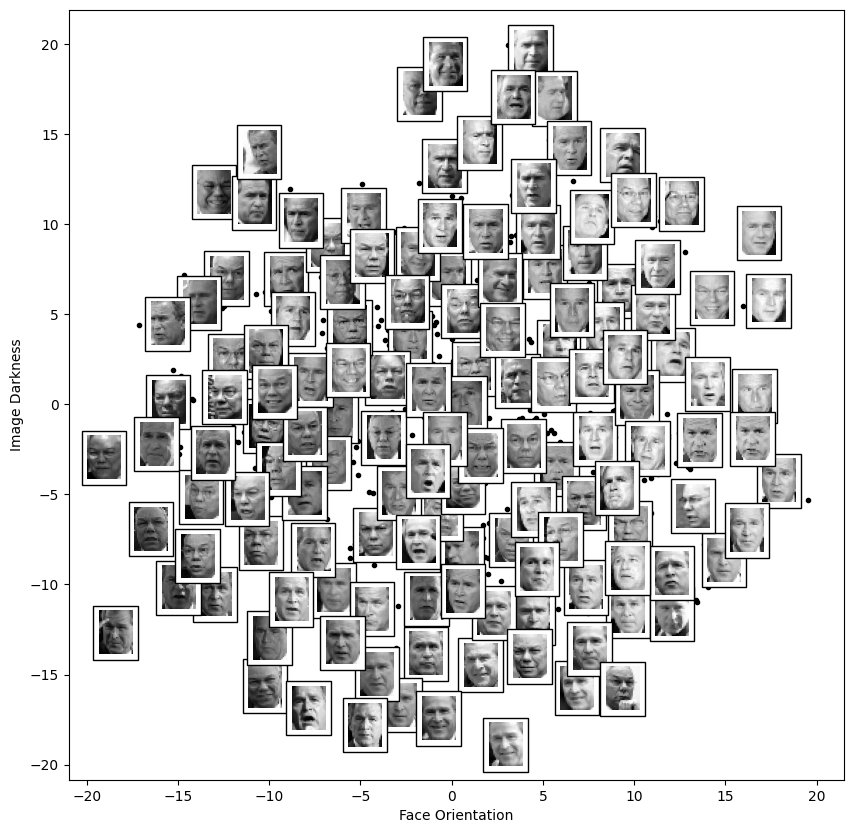

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 10),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")